In [1]:
#import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pymannkendall as mk
import cartopy.crs as ccrs
import time
import matplotlib as mpl
from scipy.stats import linregress
from scipy.cluster.vq import vq, kmeans, whiten

In [2]:
from functions import *
era_land=xr.open_dataset('eralandmask_regid.nc').rename({'lat':'latitude','lon':'longitude'})

## cluster on heat trends

In [3]:
#read data back (hw trends)
hw_slope=xr.open_dataset('hw_tmn_doy_mktrends_smoothed_1950-2021_regrid2.nc').t2m
trend_stack=hw_slope.stack(z={'latitude','longitude'}).dropna(dim='dayofyear',how='all')

bk_slope=xr.open_dataset('berkley_tmn_heat_doy_mktrends_smoothed_1950-2021_regrid2.nc').t2m
bktrend_stack=bk_slope.stack(z={'latitude','longitude'}).dropna(dim='dayofyear',how='all')

cmip_slope=xr.open_dataset('cmip_25models_hw_doy_tmean_mktrnds_1950-2021.nc').htdays
cmiptrend_stack=cmip_slope.stack(z={'latitude','longitude'}).dropna(dim='dayofyear',how='all')



#trend_stack=trend_stack.rename({'doys':'dayofyear'})



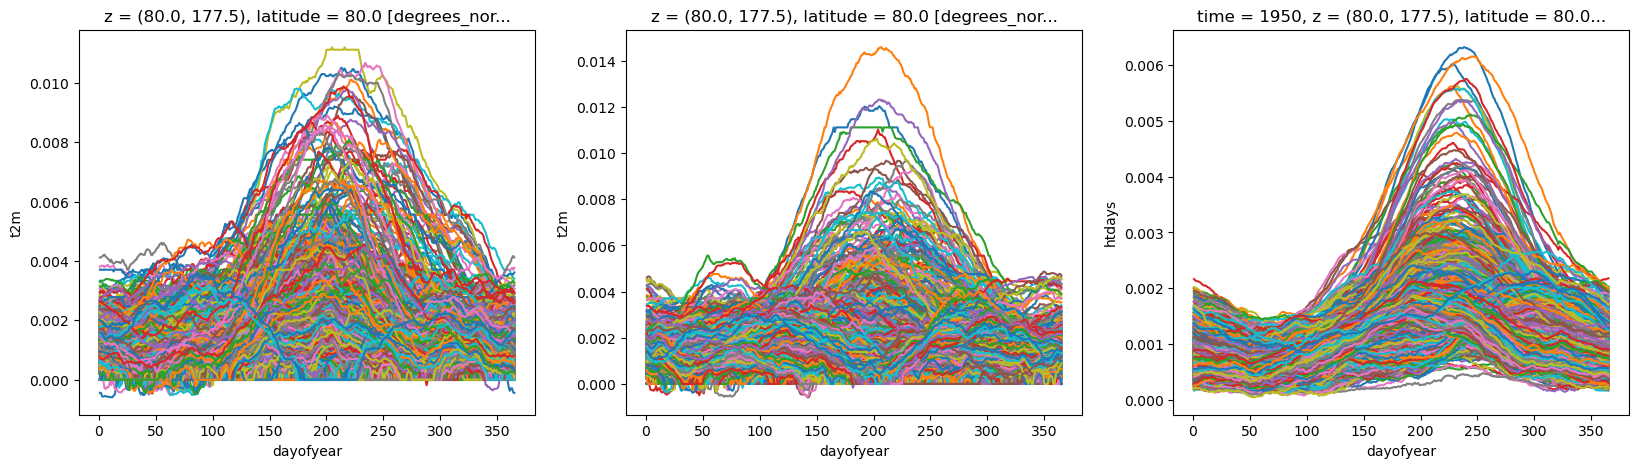

In [27]:
#plot var
cmiptrend_mmmstack=cmiptrend_stack.mean(dim='models')

fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(131)
for i in range(len(trend_stack.z)):
    trend_stack[:,i].plot(ax=ax)
ax=fig.add_subplot(132)
for i in range(len(bktrend_stack.z)):
    bktrend_stack[:,i].plot(ax=ax)
ax=fig.add_subplot(133)
for i in range(len(cmiptrend_mmmstack.z)):
    cmiptrend_mmmstack[:,i].plot(ax=ax)
plt.savefig('plots_sept/erabkcmip_mk2021.png')

In [36]:
#upper lower mean
eramn=trend_stack.mean(dim='z')
bkmn=bktrend_stack.mean(dim='z')
cmpmn=cmiptrend_mmmstack.mean(dim='z')

erastd=trend_stack.std(dim='z')
bkstd=bktrend_stack.std(dim='z')
cmpstd=cmiptrend_mmmstack.std(dim='z')

era_upper=eramn+erastd#/np.sqrt(len(trend_stack.z))
era_lower=eramn-erastd#/np.sqrt(len(trend_stack.z))

bk_upper=bkmn+bkstd#/np.sqrt(len(bktrend_stack.z))
bk_lower=bkmn-bkstd#/np.sqrt(len(bktrend_stack.z))

cmp_upper=cmpmn+cmpstd#/np.sqrt(len(cmiptrend_mmmstack.z))
cmp_lower=cmpmn-cmpstd#/np.sqrt(len(cmiptrend_mmmstack.z))

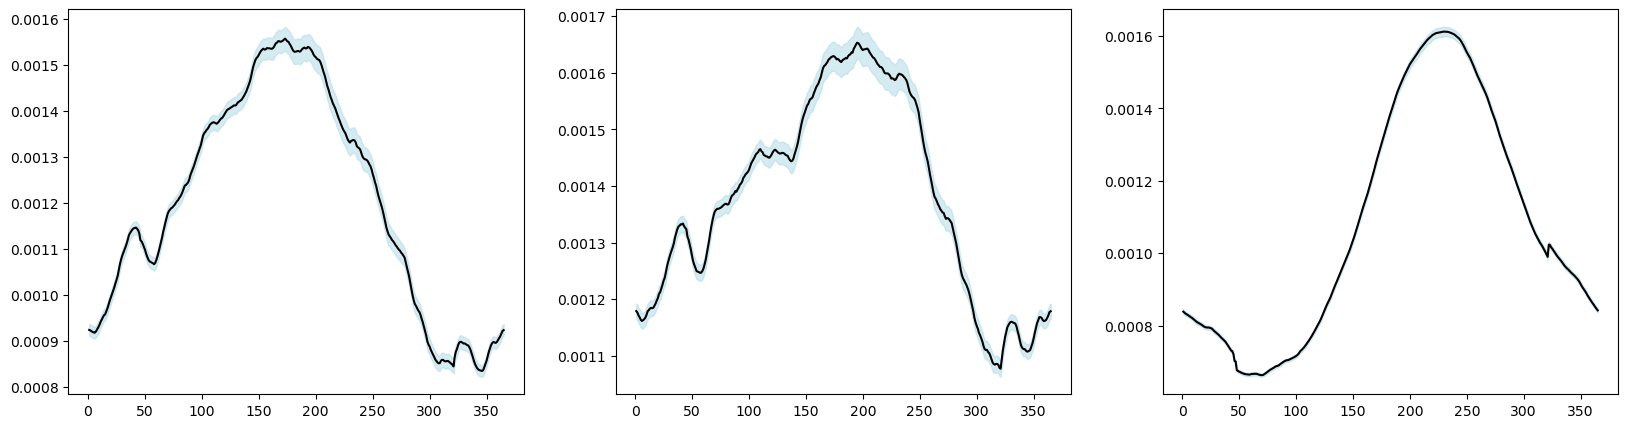

In [35]:
#plot var
cmiptrend_mmmstack=cmiptrend_stack.mean(dim='models')

fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(131)
ax.plot(eramn.dayofyear,eramn,color='k')
ax.fill_between(era_lower.dayofyear,era_lower, era_upper, color='lightblue', alpha=0.5)
   
ax=fig.add_subplot(132)
ax.plot(bkmn.dayofyear,bkmn,color='k')
ax.fill_between(bk_lower.dayofyear,bk_lower, bk_upper, color='lightblue', alpha=0.5)

ax=fig.add_subplot(133)
ax.plot(cmpmn.dayofyear,cmpmn,color='k')
ax.fill_between(cmp_lower.dayofyear,cmp_lower, cmp_upper, color='lightblue', alpha=0.5)

plt.savefig('plots_sept/erabkcmip_mean_mk2021.png')

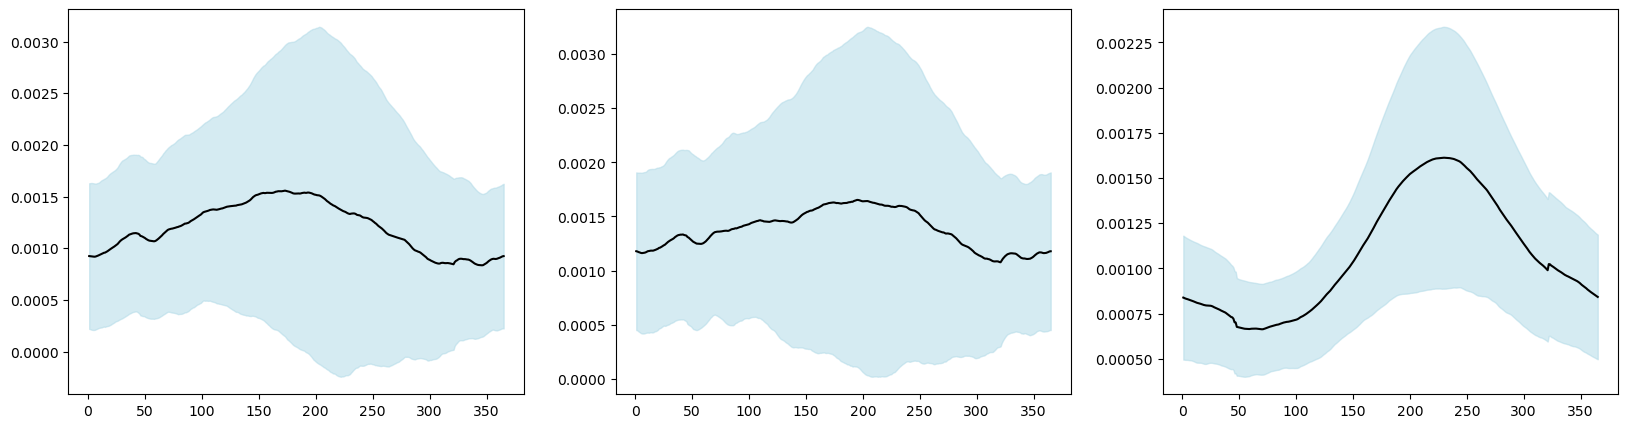

In [37]:
#plot var
cmiptrend_mmmstack=cmiptrend_stack.mean(dim='models')

fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(131)
ax.plot(eramn.dayofyear,eramn,color='k')
ax.fill_between(era_lower.dayofyear,era_lower, era_upper, color='lightblue', alpha=0.5)
   
ax=fig.add_subplot(132)
ax.plot(bkmn.dayofyear,bkmn,color='k')
ax.fill_between(bk_lower.dayofyear,bk_lower, bk_upper, color='lightblue', alpha=0.5)

ax=fig.add_subplot(133)
ax.plot(cmpmn.dayofyear,cmpmn,color='k')
ax.fill_between(cmp_lower.dayofyear,cmp_lower, cmp_upper, color='lightblue', alpha=0.5)

plt.savefig('plots_sept/erabkcmip_mean_mk2021.png')

In [8]:
#nmb fo grid points with pos trend
trend_posgrids=xr.where(trend_stack>0,1,0)
pvalera=xr.open_dataset('hw_tmn_doy_mkpvals_smoothed_1950-2024_regrid2.nc')
sig_gridsera=xr.where(pvalera.t2m<0.05,1,0)

bktrend_posgrids=xr.where(bktrend_stack>0,1,0)
pvalbk=xr.open_dataset('berkley_tmn_heat_doy_mkpvals_smoothed_1950-2021_regrid2.nc')
sig_gridsbk=xr.where(pvalbk.t2m<0.05,1,0)

cmiptrend_posgrids=xr.where(cmiptrend_stack>0,1,0)
#pvalcmip=xr.open_dataset('cmip_hw_tmn_doy_tmean_mkpvs_1950-2021.nc')
sig_gridscmp=xr.where(cmiptrend_posgrids.mean(dim='models')>0.8,1,0)

In [11]:
#sum sig grids
smera=sig_gridsera.sum(dim=['latitude','longitude'])
smbk=sig_gridsbk.sum(dim=['latitude','longitude'])
smcmp=sig_gridscmp.sum(dim='z')#.mean(dim='models')

#sm=sm.where(sm<1000)

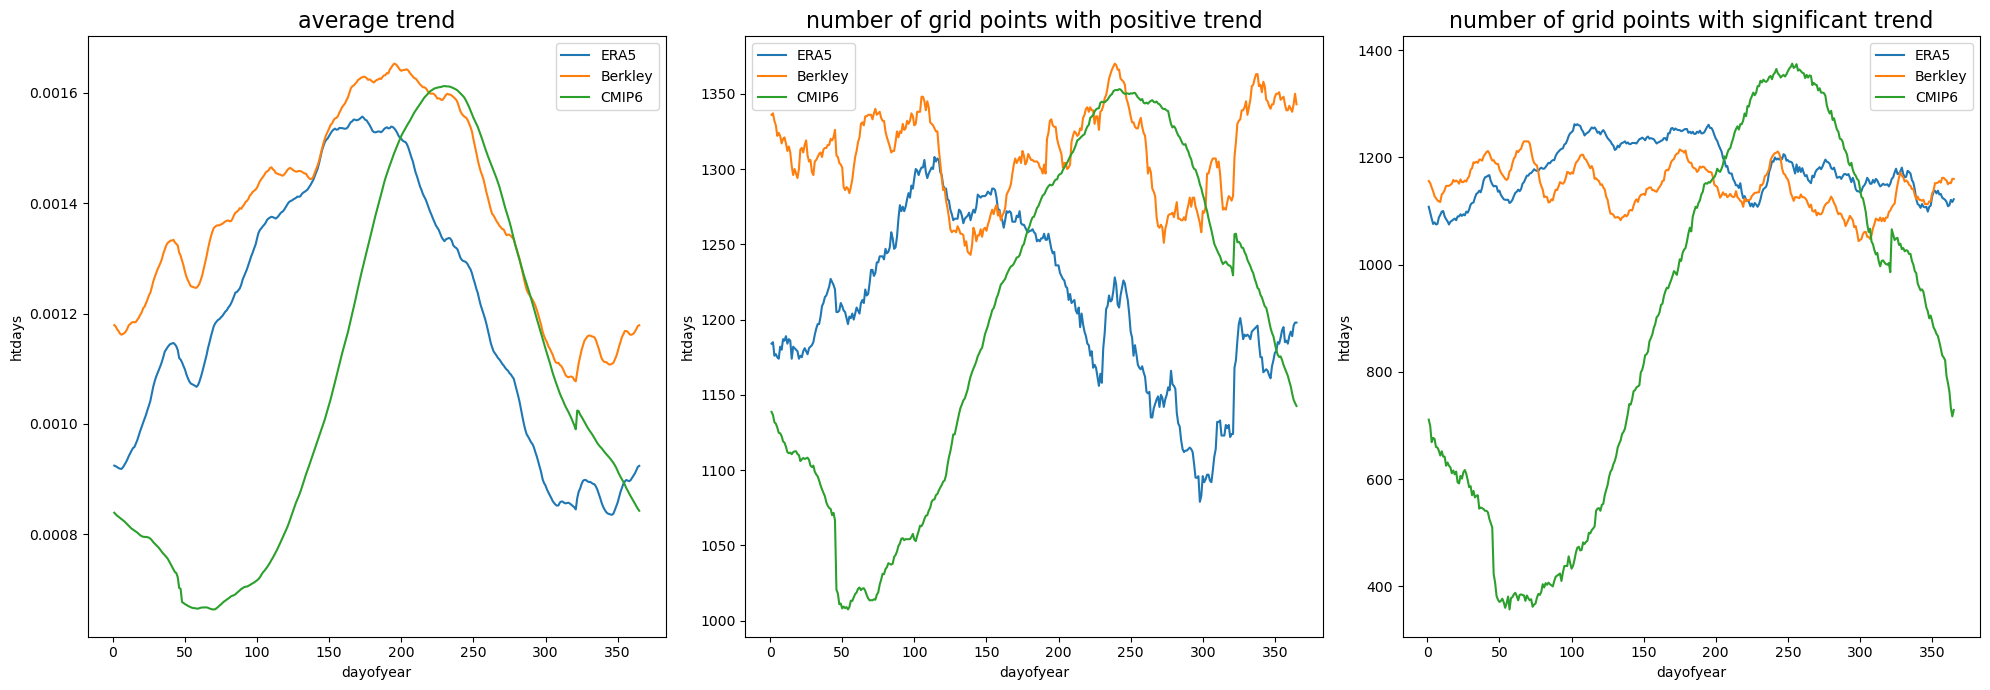

In [14]:
#plot things
fig=plt.figure(figsize=(20,7)) #add significant trends?

ax=fig.add_subplot(131)
trend_stack.mean(dim='z').plot(ax=ax, label='ERA5')
bktrend_stack.mean(dim='z').plot(ax=ax,  label='Berkley')
cmiptrend_mmmstack.mean(dim='z').plot(ax=ax,  label='CMIP6')
plt.legend()
ax.set_title('average trend', fontsize=16)
ax=fig.add_subplot(132)
trend_posgrids.sum(dim='z').plot(ax=ax, label='ERA5')
bktrend_posgrids.sum(dim='z').plot(ax=ax, label='Berkley')
cmiptrend_posgrids.sum(dim='z').mean(dim='models').plot(ax=ax, label='CMIP6')
ax.set_title('number of grid points with positive trend',fontsize=16)
plt.legend()
ax=fig.add_subplot(133)
smera.plot(ax=ax, label='ERA5')
smbk.plot(ax=ax,  label='Berkley')
smcmp.plot(ax=ax,  label='CMIP6')
plt.legend()
ax.set_title('number of grid points with significant trend', fontsize=16)

plt.tight_layout()
plt.savefig('plots_sept/trendcounts_bydoy.png')

In [4]:
#remove mean for cluster
#trend_sm_dev=trend_smoothed-trend_smoothed.mean(dim='dayofyear')
trend_sm_dev=trend_stack-trend_stack.mean(dim='dayofyear')

bktrend_sm_dev=bktrend_stack-bktrend_stack.mean(dim='dayofyear')

cmptrend_sm_dev=cmiptrend_stack-cmiptrend_stack.mean(dim='dayofyear')


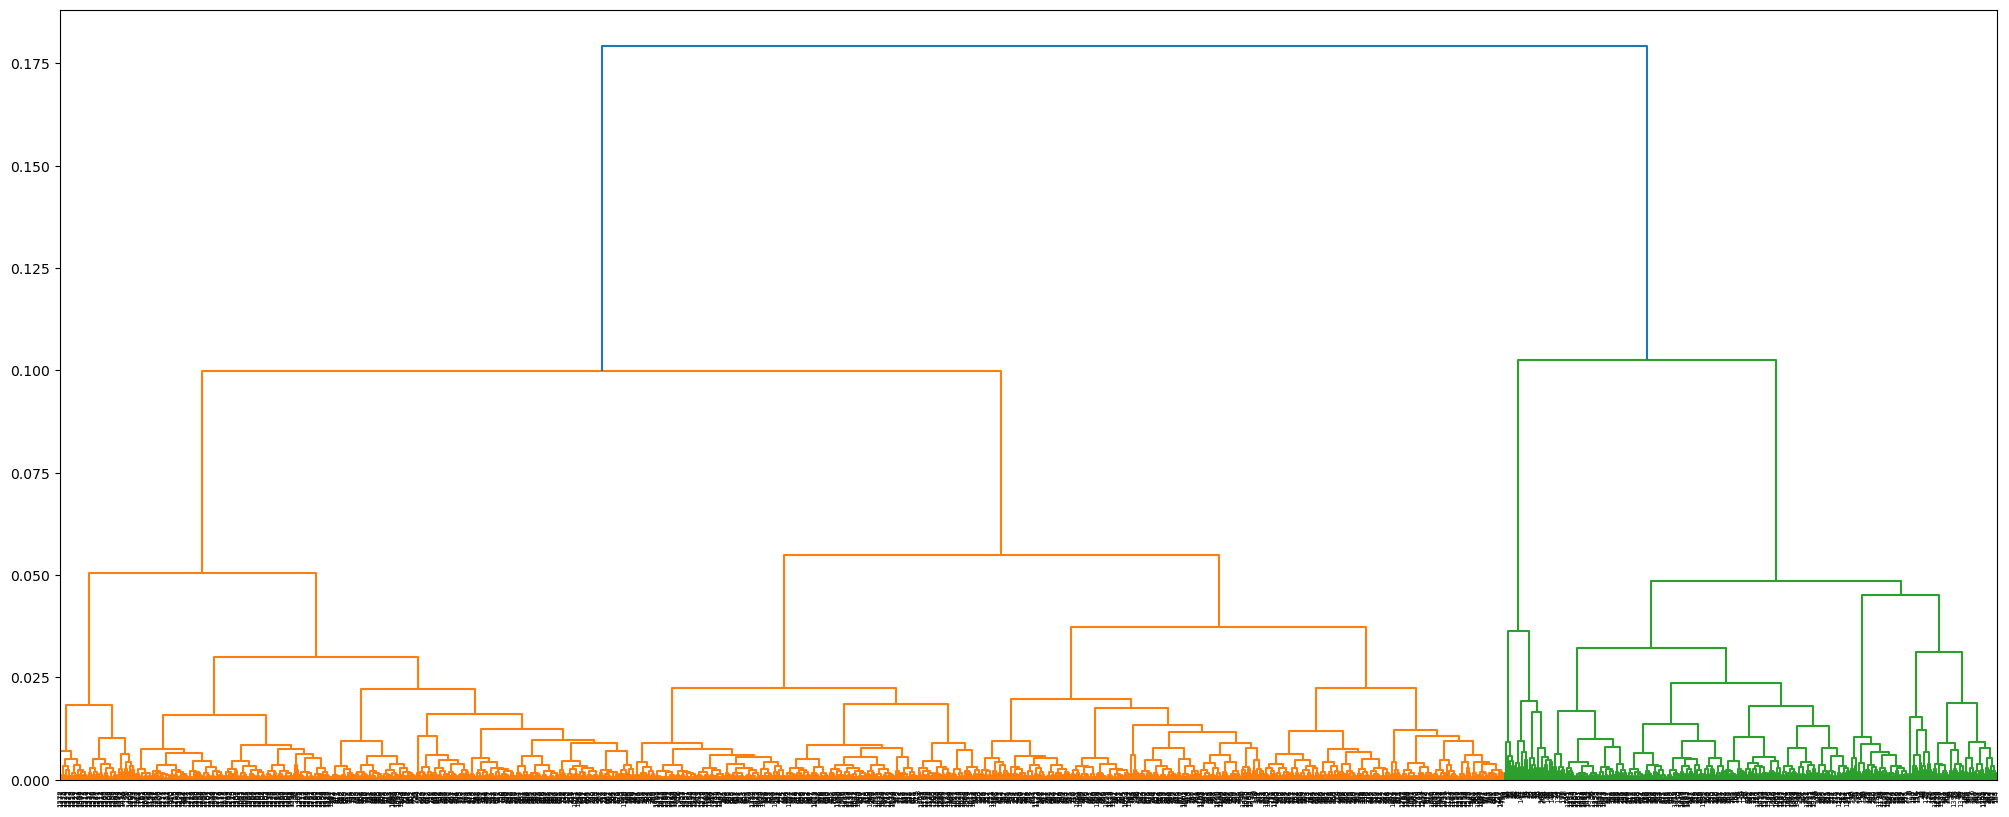

In [5]:
#Hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
cmptrend_sm_dev_na= cmptrend_sm_dev.mean(dim='models').dropna(dim='z')

Z = linkage(cmptrend_sm_dev_na.T, 'ward') #
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [6]:
def kmns_glob(dat,n):
    
    data=dat.T
    num_cl=n
    rng = np.random.default_rng(seed=2)
    whitened = whiten(data)
    centroids, mean_value =kmeans(whitened,num_cl,seed=rng)

    clusters, distances = vq(whitened, centroids)

    clusters_stack=xr.zeros_like(dat.isel(dayofyear=0).copy(deep=True))
    clusters_stack.values=clusters

    return clusters_stack,centroids

In [7]:
#clusters
cmptrend_dat=cmptrend_sm_dev.mean(dim='models').dropna(dim='z')#.to_dataset(name='t2m')

# glcluster_2,cent2=kmns_glob(trend_dat,2)
glcluster_4,cent4=kmns_glob(cmptrend_dat,4)
#glcluster_5,cent5=kmns_glob(trend_dat,5)
#glcluster_10,cent10=kmns_glob(trend_dat,10)

In [8]:
#nan vals
def unstack_nan(dat, dat_stack, dat_stackna):

    gl_un=dat_stack.isel(dayofyear=0).copy(deep=True)
    gl_nan=dat_stackna.isel(dayofyear=0).copy(deep=True)

    gl_nan.values=dat
    gl_un.loc[gl_un.z.isin(gl_nan.z)]=gl_nan
    
    out_stack=gl_un.unstack()
    
    out_stack=out_stack.transpose('latitude', 'longitude')
    return out_stack

In [9]:
#unstack cluster mask
glcluster_4cl=unstack_nan(glcluster_4,cmptrend_sm_dev.mean(dim='models'), cmptrend_dat)


In [10]:
lat_radians = np.deg2rad(bktrend_sm_dev.unstack().latitude)
weights = np.cos(lat_radians)
clustervals=glcluster_4cl+1
ones=xr.where(clustervals==1,1,np.nan)
onesarea=(ones*weights).sum(dim=['latitude', 'longitude'])
twos=xr.where(clustervals==2,1,np.nan)
twosarea=(twos*weights).sum(dim=['latitude', 'longitude'])
thres=xr.where(clustervals==3,1,np.nan)
thresarea=(thres*weights).sum(dim=['latitude', 'longitude'])
fors=xr.where(clustervals==4,1,np.nan)
forsarea=(fors*weights).sum(dim=['latitude', 'longitude'])

print(onesarea,twosarea,thresarea,forsarea)

<xarray.DataArray ()>
array(323.9042028)
Coordinates:
    dayofyear  int64 1
    time       int64 1950 <xarray.DataArray ()>
array(209.50200595)
Coordinates:
    dayofyear  int64 1
    time       int64 1950 <xarray.DataArray ()>
array(190.60632216)
Coordinates:
    dayofyear  int64 1
    time       int64 1950 <xarray.DataArray ()>
array(106.74035542)
Coordinates:
    dayofyear  int64 1
    time       int64 1950


In [11]:
#glcluster_4cl.to_dataset(name='mask').to_netcdf('era5_hwcluster_mask.nc')
#glcluster_4cl=xr.open_dataset('era5_hwcluster_mask.nc').mask

In [13]:
#CMIP equivalent


cmptemp_slope=xr.open_dataset('cmip_25models_tmean_doy_tmean_mktrnds_1950-2021.nc')
cmptempss=cmptemp_slope.tas.copy()#clim_smoother(bktemp_slope.t2m.rename({'doys':'dayofyear'}),90)


cmptempss_4cl_1=cmptempss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
cmptempss_4cl_2=cmptempss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
cmptempss_4cl_3=cmptempss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
cmptempss_4cl_4=cmptempss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

#heat
cmptrendss=cmptrend_sm_dev.unstack()

cmptrendss_4cl_1=cmptrendss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
cmptrendss_4cl_2=cmptrendss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
cmptrendss_4cl_3=cmptrendss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
cmptrendss_4cl_4=cmptrendss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

cmp_dmean=xr.open_dataset('cmip6_tas_day_hist-ssp_25models_1950-2021_regridcon.nc').load()
cmp_dmean=cmp_dmean.sortby(cmp_dmean.time)
#cmp_dmean=cmp_dmean.rename({'lat':'latitude','lon':'longitude'})
cmp_dmean=rotlon_180(cmp_dmean)
cmptemp_midlat=cutmidlat(cmp_dmean)
cmptemp_midlat=landmask(cmptemp_midlat)
cmptemp_noleap=cmptemp_midlat.convert_calendar('noleap')
#

#cmptemp_noleap2=cmptemp_noleap.sel(time=slice('1979-01-01','2014-12-31'))
cmptemp_sdrol=cmptemp_noleap.tas.rolling(time=10,center=True).construct('window')
cmptemp_sdgp=cmptemp_sdrol.groupby('time.dayofyear')
#heat_doygp=heat_noleap.t2m.groupby('time.dayofyear')
cmptemp_doysd=cmptemp_noleap.tas.groupby('time.year').mean().expand_dims({'doys':np.arange(1,366)}).copy().rename({'year':'time'})
cmptemp_doygp=cmptemp_noleap.tas.groupby('time.dayofyear')
for i in range(len(cmptemp_doygp)):
#     if i!=59:
    curgp=cmptemp_sdgp[i+1].copy().assign_coords(time=cmptemp_doysd[i].time)
    cmptemp_doysd[i,]=curgp.std(dim='window')
 #.sel(doys=cmptemp_doysd.doys!=60)

cmptemp_doysd2=cmptemp_doysd.mean(dim='time')
cmpvar_stack=cmptemp_doysd2.rename({'doys':'dayofyear'}).stack(z={'latitude','longitude'})
cmpvar_st_smoothed=clim_smoother(cmpvar_stack,90)
#smooth

cmpvar_sm_dev=cmpvar_st_smoothed-cmpvar_st_smoothed.mean(dim='dayofyear')

#
cmpvarss=cmpvar_sm_dev.unstack()

cmpvarss_4cl_1=cmpvarss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
cmpvarss_4cl_2=cmpvarss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
cmpvarss_4cl_3=cmpvarss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
cmpvarss_4cl_4=cmpvarss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

In [14]:
#era5 eq
temp_slope=xr.open_dataset('tmean_doy_mktrends_1950-2024_regrid.nc')
tempss=temp_slope.t2m.copy()#clim_smoother(temp_slope.t2m.rename({'doys':'dayofyear'}),90)

tempss_4cl_1=tempss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
tempss_4cl_2=tempss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
tempss_4cl_3=tempss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
tempss_4cl_4=tempss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

#heat
trendss=trend_sm_dev.unstack()

trendss_4cl_1=trendss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
trendss_4cl_2=trendss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
trendss_4cl_3=trendss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
trendss_4cl_4=trendss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

era_dmean=xr.open_dataset('era5/era5_tmean_daily_1950_2024_regridcon.nc').load()
era_dmean=era_dmean.sortby(era_dmean.time)
era_dmean=era_dmean.rename({'lat':'latitude','lon':'longitude'})
era_dmean=rotlon_180(era_dmean)
temp_midlat=cutmidlat(era_dmean)
temp_midlat=landmask(temp_midlat)
temp_noleap=temp_midlat.convert_calendar('noleap')
#

temp_sdrol=temp_noleap.t2m.rolling(time=10,center=True).construct('window')
temp_sdgp=temp_sdrol.groupby('time.dayofyear')
#heat_doygp=heat_noleap.t2m.groupby('time.dayofyear')
temp_doysd=temp_noleap.t2m.groupby('time.year').mean().expand_dims({'doys':np.arange(1,366)}).copy().rename({'year':'time'})
temp_doygp=temp_noleap.t2m.groupby('time.dayofyear')
for i in range(len(temp_doygp)):
#     if i!=59:
    curgp=temp_sdgp[i+1].copy().assign_coords(time=temp_doysd[i].time)
    temp_doysd[i,]=curgp.std(dim='window')
 #.sel(doys=temp_doysd.doys!=60)

#temp_dvar=sd_doymn(temp_doytimes,10)

temp_doysd2=temp_doysd.mean(dim='time')
var_stack=temp_doysd2.rename({'doys':'dayofyear'}).stack(z={'latitude','longitude'})
var_st_smoothed=clim_smoother(var_stack,90)

#variability in clusters

#remove mean for cluster
var_sm_dev=var_st_smoothed-var_st_smoothed.mean(dim='dayofyear')

varss=var_sm_dev.unstack()

varss_4cl_1=varss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
varss_4cl_2=varss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
varss_4cl_3=varss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
varss_4cl_4=varss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

In [15]:
#Berk equivalent
bktemp_slope=xr.open_dataset('bk_tmean_doy_mktrends_1950-2021_regrid.nc')
bktempss=bktemp_slope.t2m.copy()#clim_smoother(bktemp_slope.t2m.rename({'doys':'dayofyear'}),90)


bktempss_4cl_1=bktempss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
bktempss_4cl_2=bktempss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
bktempss_4cl_3=bktempss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
bktempss_4cl_4=bktempss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

bktrendss=bktrend_sm_dev.unstack()

bktrendss_4cl_1=bktrendss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
bktrendss_4cl_2=bktrendss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
bktrendss_4cl_3=bktrendss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
bktrendss_4cl_4=bktrendss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

bk_dmean=xr.open_dataset('berkley_tmean_1950-2021_regridcon.nc').load()
bk_dmean=bk_dmean.sortby(bk_dmean.time)
bk_dmean=bk_dmean.rename({'lat':'latitude','lon':'longitude'})
bk_dmean=rotlon_180(bk_dmean)
bktemp_midlat=cutmidlat(bk_dmean)
bktemp_midlat=landmask(bktemp_midlat)
bktemp_noleap=bktemp_midlat.convert_calendar('noleap')
#

#bktemp_noleap2=bktemp_noleap.sel(time=slice('1979-01-01','2014-12-31'))
bktemp_sdrol=bktemp_noleap.temperature.rolling(time=10,center=True).construct('window')
bktemp_sdgp=bktemp_sdrol.groupby('time.dayofyear')
#heat_doygp=heat_noleap.t2m.groupby('time.dayofyear')
bktemp_doysd=bktemp_noleap.temperature.groupby('time.year').mean().expand_dims({'doys':np.arange(1,366)}).copy().rename({'year':'time'})
bktemp_doygp=bktemp_noleap.temperature.groupby('time.dayofyear')
for i in range(len(bktemp_doygp)):
#     if i!=59:
    curgp=bktemp_sdgp[i+1].copy().assign_coords(time=bktemp_doysd[i].time)
    bktemp_doysd[i,]=curgp.std(dim='window')
 #.sel(doys=bktemp_doysd.doys!=60)

bktemp_doysd2=bktemp_doysd.mean(dim='time')
bkvar_stack=bktemp_doysd2.rename({'doys':'dayofyear'}).stack(z={'latitude','longitude'})
bkvar_st_smoothed=clim_smoother(bkvar_stack,90)
#smooth

bkvar_sm_dev=bkvar_st_smoothed-bkvar_st_smoothed.mean(dim='dayofyear')

#
bkvarss=bkvar_sm_dev.unstack()

bkvarss_4cl_1=bkvarss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
bkvarss_4cl_2=bkvarss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
bkvarss_4cl_3=bkvarss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
bkvarss_4cl_4=bkvarss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

In [16]:
#normalize

def normdat(dat):
    dat_norm = 2 * ((dat - dat.min()) / (dat.max() - dat.min())) - 1
    return dat_norm

In [17]:
def revdec_doy(dat,num=365):
    dat1=dat.copy(deep=True)
    dat1.coords['dayofyear']=xr.where(dat1['dayofyear']>334,dat1['dayofyear']-num,dat1['dayofyear'])
    dat_out=  dat1.sortby(dat1.dayofyear)
    return dat_out

In [20]:
clustervalsn=glcluster_4cl+1
# xr.where(glcluster_4cl+1==4,1,glcluster_4cl+1)
# clustervalsn=xr.where(glcluster_4cl+1==3,2,clustervalsn)
# clustervalsn=xr.where(glcluster_4cl+1==2,3,clustervalsn)
# clustervalsn=xr.where(glcluster_4cl+1==1,4,clustervalsn)

In [21]:
ones=clustervalsn.where(clustervalsn==1).count()
twos=clustervalsn.where(clustervalsn==2).count()
thres=clustervalsn.where(clustervalsn==3).count()
fors=clustervalsn.where(clustervalsn==4).count()

print(ones,twos,thres,fors)

<xarray.DataArray 'htdays' ()>
array(541)
Coordinates:
    dayofyear  int64 1
    time       int64 1950 <xarray.DataArray 'htdays' ()>
array(431)
Coordinates:
    dayofyear  int64 1
    time       int64 1950 <xarray.DataArray 'htdays' ()>
array(353)
Coordinates:
    dayofyear  int64 1
    time       int64 1950 <xarray.DataArray 'htdays' ()>
array(142)
Coordinates:
    dayofyear  int64 1
    time       int64 1950


In [23]:
#plot
from matplotlib import cm
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import string

letters=[]
for letter in string.ascii_lowercase[0:24]:
    letters.append(letter+". ")

erahw=[trendss_4cl_1,trendss_4cl_2,trendss_4cl_3,trendss_4cl_4]
eratemp=[tempss_4cl_1,tempss_4cl_2,tempss_4cl_3,tempss_4cl_4]
eravar=[varss_4cl_1,varss_4cl_2,varss_4cl_3,varss_4cl_4]

bkhw=[bktrendss_4cl_1,bktrendss_4cl_2,bktrendss_4cl_3,bktrendss_4cl_4]
bktemp=[bktempss_4cl_1,bktempss_4cl_2,bktempss_4cl_3,bktempss_4cl_4]
bkvar=[bkvarss_4cl_1,bkvarss_4cl_2,bkvarss_4cl_3,bkvarss_4cl_4]

cmphw=[cmptrendss_4cl_1,cmptrendss_4cl_2,cmptrendss_4cl_3,cmptrendss_4cl_4]
cmptemp=[cmptempss_4cl_1,cmptempss_4cl_2,cmptempss_4cl_3,cmptempss_4cl_4]
cmpvar=[cmpvarss_4cl_1,cmpvarss_4cl_2,cmpvarss_4cl_3,cmpvarss_4cl_4]


fig=plt.figure(figsize=(16,8))

gs = fig.add_gridspec(4,4)
jet = cm.get_cmap('jet')
jet_2_colors = jet(np.linspace(0, 1, 4))
#plm=mpl.colormaps['plasma'].colors
#     ax=fig.add_subplot(gs[i, 0],projection=ccrs.PlateCarree())
category_colors = jet_2_colors
category_labels = ['Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4']
cmap = mcolors.ListedColormap(category_colors)

bounds = np.arange(1,6)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

ax=fig.add_subplot(gs[0,0:5],projection=ccrs.PlateCarree())
plot=(clustervalsn).plot(ax=ax,cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),add_colorbar=False)#cbar_kwargs={'orientation':'horizontal','ticks':[1,2,3,4]})

# legend_handles = [Patch(facecolor=jet_2_colors[i], label=category_labels[i]) for i in range(len(jet_2_colors))]

#     # Add the legend to the plot
# ax.legend(handles=legend_handles, loc='lower left',fontsize=14)

handles = [Patch(facecolor=jet_2_colors[i], label=category_labels[i]) for i in range(len(jet_2_colors))]
# labels=[]
# h, l = ax2.get_legend_handles_labels()
# handles.extend(h)
# labels.extend(l)

fig.legend(handles, category_labels, loc='lower center', fontsize=14, bbox_to_anchor=(0.2, 0.775))

#legend.set_title('')
# plot.colorbar.set_label(label='', size=12)
# plot.colorbar.ax.set_title(label='Clusters', size=12)
# plot.colorbar.ax.tick_params(labelsize=12)
ax.set_title(letters[0],loc='left',fontsize=16)
ax.set_title('Berkeley clusters',fontsize=16)
#ax.legend()
ax.coastlines()

xticks=np.array([1,91,183,275])
xticklabels=['D','M','J','S']

order_cluster=[0,1,2,3]
for i in range(4):
    ax2=fig.add_subplot(gs[1,i])
    jet = cm.get_cmap('jet')
    #jet_2_colors = jet(np.linspace(0, 1, 2))
    ax2.plot(bktrend_stack.dayofyear,revdec_doy(normdat(bkhw[order_cluster[i]])), linewidth=3, c=jet_2_colors[0],label='Hot spell days trend')
    ax2.plot(bktempss_4cl_1.dayofyear,revdec_doy(normdat(bktemp[order_cluster[i]])),  linewidth=3,linestyle='-.',c=jet_2_colors[1],label='Temperature trend')
    ax2.plot(bkvarss_4cl_1.dayofyear,revdec_doy(-normdat(bkvar[order_cluster[i]])), linewidth=3,linestyle='--',c=jet_2_colors[3],label='Temperature variability')
    #ax2.plot(trend_stack.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
    ax2.set_xticklabels('')
    ax2.set_title(letters[i+1],loc='left',fontsize=16)
    ax2.set_title('Cluster '+str(i+1), fontsize=16)
    if i !=0:
        ax2.set_yticks([])
    else:
        ax2.set_ylabel('Berkeley', fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

    ax2=fig.add_subplot(gs[2,i])
    
    jet = cm.get_cmap('jet')
    jet_2_colors = jet(np.linspace(0, 1, 4))
    ax2.plot(trend_stack.dayofyear,revdec_doy(normdat(erahw[order_cluster[i]])), linewidth=3, c=jet_2_colors[0],label='Hot spell days trend')
    ax2.plot(tempss_4cl_1.dayofyear,revdec_doy(normdat(eratemp[order_cluster[i]])), linewidth=3,linestyle='-.',c=jet_2_colors[1],label='Temperature trend')
    ax2.plot(varss_4cl_1.dayofyear,revdec_doy(-normdat(eravar[order_cluster[i]])), linewidth=3,linestyle='--',c=jet_2_colors[3],label='Temperature variability')
    #ax2.plot(trend_stack.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
    ax2.set_title(letters[i+5],loc='left',fontsize=16)
    
    #ax2.set_xticks(xticks)
    ax2.set_xticklabels('')
    if i !=0:
        ax2.set_yticks([])
    else:
        ax2.set_ylabel('ERA5', fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    ax2=fig.add_subplot(gs[3,i])
    jet = cm.get_cmap('jet')
    #jet_2_colors = jet(np.linspace(0, 1, 2))
    ax2.plot(cmiptrend_stack.dayofyear,revdec_doy(normdat(cmphw[order_cluster[i]].mean(dim='models'))), linewidth=3, c=jet_2_colors[0],label='Hot spell days trend')
    ax2.plot(cmptempss_4cl_1.dayofyear,revdec_doy(normdat(cmptemp[order_cluster[i]].mean(dim='models'))), linewidth=3,linestyle='-.',c=jet_2_colors[1],label='Temperature trend')
    ax2.plot(cmpvarss_4cl_1.dayofyear,revdec_doy(-normdat(cmpvar[order_cluster[i]].mean(dim='models'))), linewidth=3,linestyle='--',c=jet_2_colors[3],label='Temperature variability')
    #ax2.plot(trend_stack.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
    ax2.set_title(letters[i+9],loc='left',fontsize=16)
    if i !=0:
        ax2.set_yticks([])
    else:
        ax2.set_ylabel('CMIP6', fontsize=14)
#     if i==3:
#         plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0.75), fontsize=12)
    
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticklabels)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    
    x_start = xticks[0]
    x_end = xticks[1]


handles=[]
labels=[]
h, l = ax2.get_legend_handles_labels()
handles.extend(h)
labels.extend(l)

fig.legend(handles, labels,ncol=3, loc='lower center', fontsize=14, bbox_to_anchor=(0.5, 0))

plt.tight_layout()
plt.subplots_adjust( left=0.1,bottom=0.1)
plt.savefig('plots_more/cmip_clusters_supporting.png')